<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from VariationalModel import *
from Functions import *
from Classes import *

In [3]:
generate_index(file="Restyle.ipynb")


<h1 style="color:black; font-size: 38px; font-weight: 700; margin-bottom: 5px;">
    Index
</h1>

<hr style="border: 1px solid #000;">

<p style="font-size: 18px; color:black; margin-top: 10px;">

</p>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#1-Introduction" style="color:black; text-decoration:none;">1. Introduction</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Theoretical-Background" style="color:black; text-decoration:none;">Theoretical Background</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#General-Parameters-Setup" style="color:black; text-decoration:none;">General Parameters Setup</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Dataset-Description" style="color:black; text-decoration:none;">Dataset Description</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#2-General-set-up" style="color:black; text-decoration:none;">2. General set up</a></span><br>
<br>
<hr style="border: 1px solid #000;">
<br>


# 1. Introduction

## Theoretical Background  

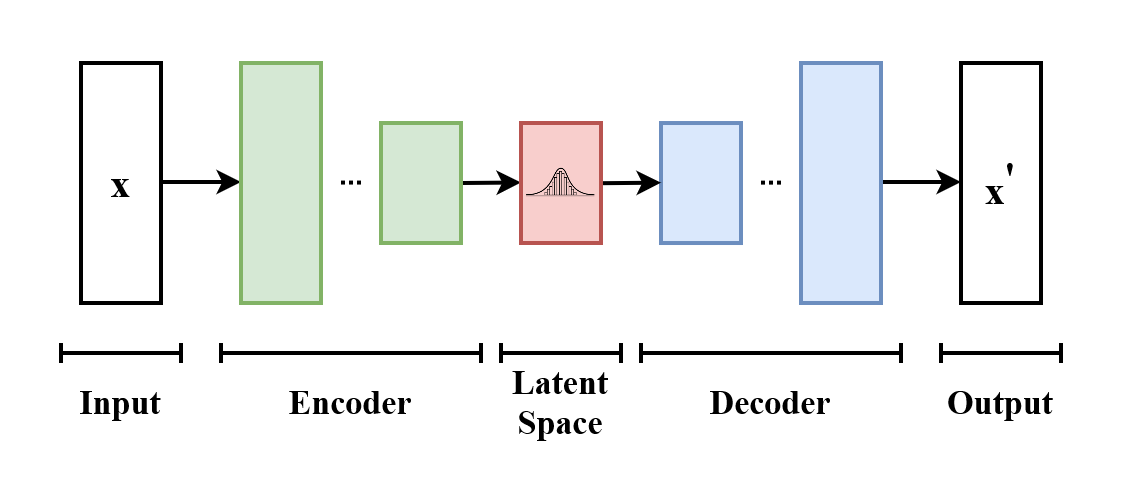

In [4]:
Image(filename="Images/VAE_Basic.png", width=600, height=500)

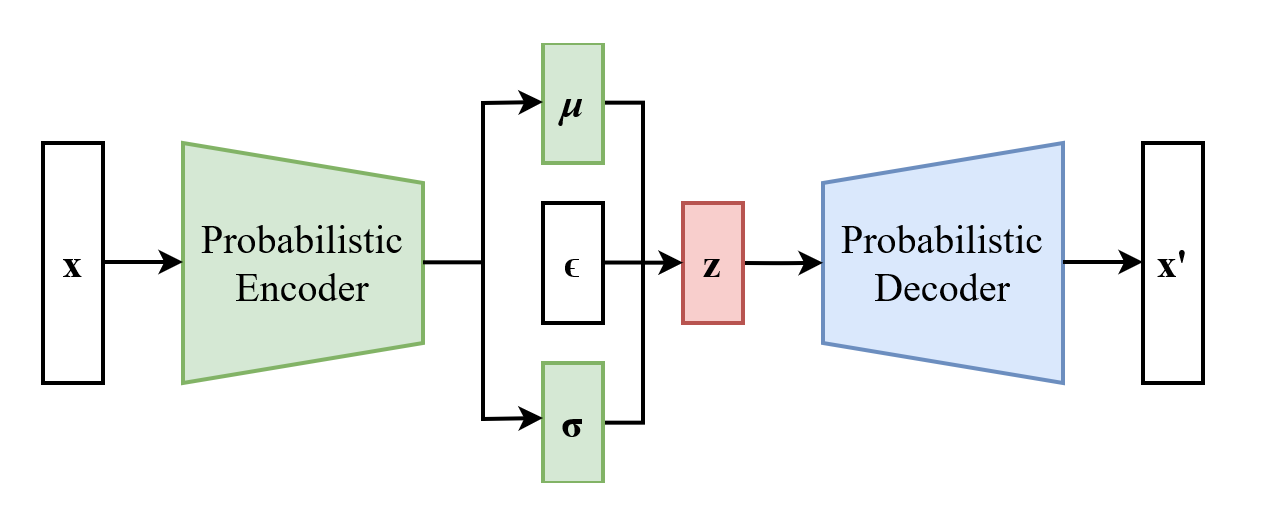

In [5]:
Image(filename="Images/Reparameterized_Variational_Autoencoder.png", width=600, height=500)

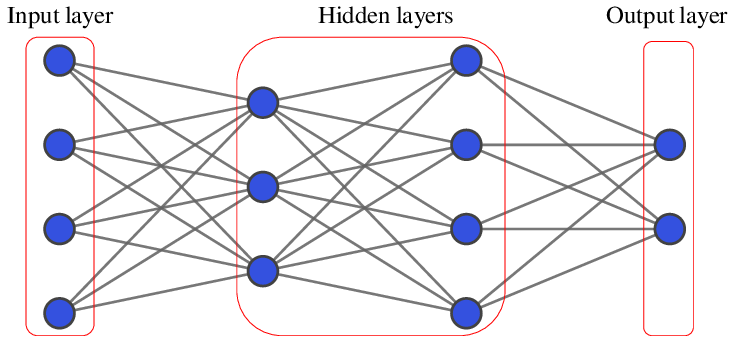

In [6]:
Image(filename="Images/FFNN.png", width=500, height=400)

## General Parameters Setup

In [7]:
binarize   = False
batch_size = 250

## Dataset Description

In [8]:
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

Selected device: cuda


In [9]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)
print(f"Length of the train dataset: {len(trainDataset)}")
print(f"Length of the test dataset: {len(testDataset)}")

Length of the train dataset: 60000
Length of the test dataset: 10000


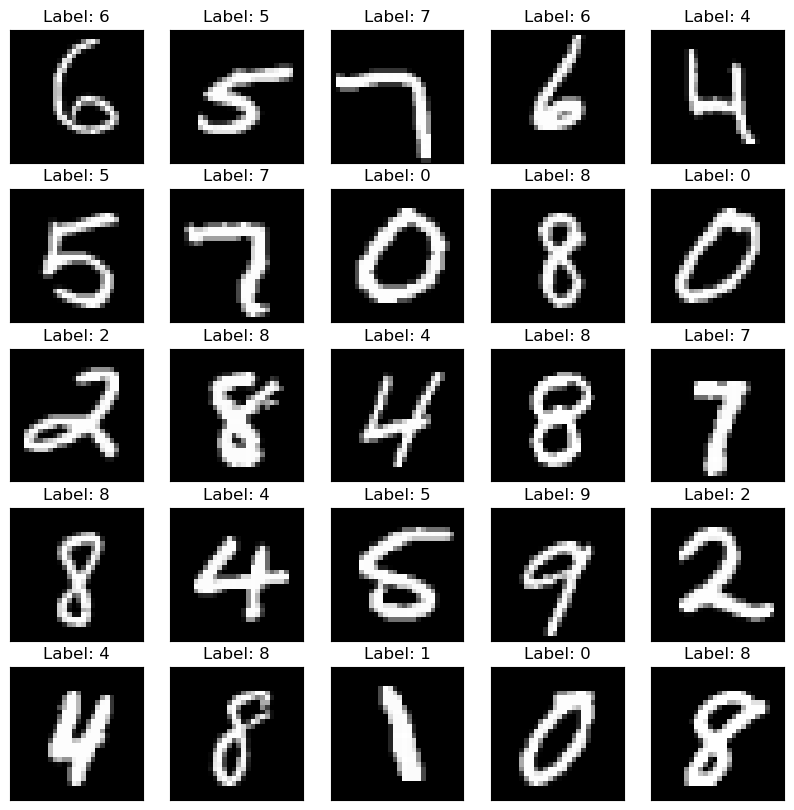

In [10]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [11]:
#Transforms in pytorch tensors
operations = [transforms.ToTensor()]
if binarize:
    operations.append( transforms.Lambda(lambda x: (x > 0.5).float()) )

final_transform = transforms.Compose(operations)
trainDataset.transform = final_transform
testDataset.transform  = final_transform

In [12]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([250, 1, 28, 28])
	 Labels: torch.Size([250])
TEST BATCH SHAPE
	 Data: torch.Size([250, 1, 28, 28])
	 Labels: torch.Size([250])


# 2. General set up

In [13]:
from typing import Dict, Any, Optional
import torch.optim as optim

In [14]:
# ==========================================
# CONFIGURATION OBJECT
# ==========================================

class ExperimentConfig:
    def __init__(self, 
                 name: str, 
                 model_params: Dict[str, Any], 
                 train_params: Dict[str, Any], 
                 mi_params: Dict[str, Any],
                 channel_analysis_params: Optional[Dict[str, Any]] = None):
        """
        Configuration container for a single experiment.
        
        Args:
            name: Unique ID for the experiment.
            model_params: Dict passed to VariationalAutoEncoder (hidden_dims, etc.)
            train_params: Dict with 'lr', 'epochs'.
            mi_params: Dict with 'method' (kde/kraskov), 'sigma', 'n_neig'.
            channel_analysis_params: (Optional) Dict to run noise analysis after training.
                                     Ex: {'noise_type': 'bitflip', 'param': 0.1}
        """
        self.name = name
        self.model_params = model_params
        self.train_params = train_params
        self.mi_params = mi_params
        self.channel_analysis_params = channel_analysis_params

In [15]:
# ==========================================
# THE FRAMEWORK (TRAINER)
# ==========================================

class VAEFramedTrainer:
    def __init__(self, train_loader, test_loader, device):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device


    def run(self, config: ExperimentConfig):
        print(f"\n{'='*15} STARTING EXPERIMENT: {config.name} {'='*15}")
        
        # --- PHASE 1: INITIALIZATION ---
        # Initialize the model using the parameters dictionary
        model = VariationalAutoEncoder(**config.model_params).to(self.device)

        # Setup loss function
        loss_fn = torch.nn.MSELoss()
        
        # Setup Optimizer
        lr = config.train_params.get("lr", 1e-3)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Setup Recorders & Estimators
        recorder = ActivationRecorder()
        recorder.InitialRegister(model)
        
        mi_estimator = MI_Estimator(
            method=config.mi_params.get("method", "kmeans"),
            sigma=config.mi_params.get("sigma", 1.0),
            n_neig=config.mi_params.get("n_neig", 3)
        )
        mi_history = MI_History()
        
        # --- PHASE 2: TRAINING LOOP ---
        epochs = config.train_params.get("epochs", 20)
        model.train()
        
        for epoch in range(1, epochs + 1):
            train_loss = 0
            for batch_idx, (data, _) in enumerate(self.train_loader):
                # Flatten image [Batch, 1, 28, 28] -> [Batch, 784]
                data = data.to(self.device).view(data.size(0), -1)
                
                optimizer.zero_grad()
                
                # Forward Pass
                x_hat, z, mean, logVar = model(data)
                
                # Loss & Backward
                loss = loss_fn(data, x_hat)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            avg_loss = train_loss / len(self.train_loader.dataset)
            print(f"[{config.name}] Epoch {epoch}/{epochs} | Loss: {avg_loss:.5f}")
            model.train_loss_history.append(avg_loss)

            # Mutual Information Calculation (if VAE_info function is available)
            mi_data = VAE_info(
                 model=model, 
                 dataset=self.test_loader.dataset, 
                 device=self.device, 
                 epoch=epoch, 
                 num_samples=1000, 
                 mi_estimator=mi_estimator, 
                 RecorderActivat=recorder
            )
            mi_history.append(mi_data)

        # # --- PHASE 3: POST-TRAINING ANALYSIS (CHANNEL ROBUSTNESS) ---
        # channel_results = None
        # if config.channel_analysis_params:
        #     # Calls the ChannelAnalyzer tool defined above
        #     channel_results = ChannelAnalyzer.compare_performance(
        #         model=model,
        #         dataset=self.test_loader.dataset,
        #         device=self.device,
        #         noise_type=config.channel_analysis_params.get("noise_type", "gaussian"),
        #         param=config.channel_analysis_params.get("param", 0.5),
        #         renorm=True
        #     )

        print(f"{'='*15} EXPERIMENT COMPLETED: {config.name} {'='*15}\n")
        
        # Return all artifacts for further plotting/analysis
        return {
            "config": config,
            "model": model,
            "optimizer": optimizer,
            "recorder": recorder,
            "mi_history": mi_history,
            #"channel_results": channel_results,
            "final_loss": avg_loss
        }

In [16]:
trainer = VAEFramedTrainer(trainDataloader, testDataloader, device)

In [17]:
exp = ExperimentConfig(
    name="Baseline_Model",
    model_params={"inputDim": 784, "hiddenDim": [400,200,100], "latentDim": 20, 
        "temperature": 1.0, "binarize": "no"},
    train_params={"lr": 1e-3, "epochs": 50},
    mi_params={"method": "kde", "sigma": 1},
    channel_analysis_params=None
)

In [18]:
results = trainer.run(exp)


=============== STARTING EXPERIMENT: Baseline_Model ===============
[Baseline_Model] Epoch 1/50 | Loss: 0.00027
[Baseline_Model] Epoch 2/50 | Loss: 0.00017
[Baseline_Model] Epoch 3/50 | Loss: 0.00012
[Baseline_Model] Epoch 4/50 | Loss: 0.00010
[Baseline_Model] Epoch 5/50 | Loss: 0.00009
[Baseline_Model] Epoch 6/50 | Loss: 0.00008
[Baseline_Model] Epoch 7/50 | Loss: 0.00007
[Baseline_Model] Epoch 8/50 | Loss: 0.00007
[Baseline_Model] Epoch 9/50 | Loss: 0.00006
[Baseline_Model] Epoch 10/50 | Loss: 0.00006
[Baseline_Model] Epoch 11/50 | Loss: 0.00006
[Baseline_Model] Epoch 12/50 | Loss: 0.00006
[Baseline_Model] Epoch 13/50 | Loss: 0.00005
[Baseline_Model] Epoch 14/50 | Loss: 0.00005
[Baseline_Model] Epoch 15/50 | Loss: 0.00005
[Baseline_Model] Epoch 16/50 | Loss: 0.00005
[Baseline_Model] Epoch 17/50 | Loss: 0.00005
[Baseline_Model] Epoch 18/50 | Loss: 0.00004
[Baseline_Model] Epoch 19/50 | Loss: 0.00004
[Baseline_Model] Epoch 20/50 | Loss: 0.00004
[Baseline_Model] Epoch 21/50 | Loss: 0.0

In [20]:
results

{'config': <__main__.ExperimentConfig at 0x7441674a0320>,
 'model': VariationalAutoEncoder(
   (InputSpace): Identity()
   (Encoder): Sequential(
     (0): Sequential(
       (0): Linear(in_features=784, out_features=400, bias=True)
       (1): ReLU()
     )
     (1): Sequential(
       (0): Linear(in_features=400, out_features=200, bias=True)
       (1): ReLU()
     )
     (2): Sequential(
       (0): Linear(in_features=200, out_features=100, bias=True)
       (1): ReLU()
     )
   )
   (LatentLayerMu): Linear(in_features=100, out_features=20, bias=True)
   (LatentLayerSigma): Linear(in_features=100, out_features=20, bias=True)
   (LatentSpace): Identity()
   (Decoder): Sequential(
     (0): Sequential(
       (0): Linear(in_features=20, out_features=100, bias=True)
       (1): ReLU()
     )
     (1): Sequential(
       (0): Linear(in_features=100, out_features=200, bias=True)
       (1): ReLU()
     )
     (2): Sequential(
       (0): Linear(in_features=200, out_features=400, bias=Tr

In [21]:
results['mi_history'].show()

.latent_output
.input_latent

==================== MI HISTORY (all) ====================
EPOCH 1
  [Global] I(Input, Z): 0.532 | I(Z, Output): 0.531
  [Encoder]
    Layer 1: I(Input, L)=0.067 | I(L, Z)=0.515
    Layer 2: I(Input, L)=0.235 | I(L, Z)=0.511
    Layer 3: I(Input, L)=0.506 | I(L, Z)=0.534
  [Decoder]
    Layer 1: I(Z, L)=0.468     | I(L, Output)=0.147
    Layer 2: I(Z, L)=0.504     | I(L, Output)=0.123
    Layer 3: I(Z, L)=0.547     | I(L, Output)=0.232
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 1.653 | I(Z, Output): 1.653
  [Encoder]
    Layer 1: I(Input, L)=0.125 | I(L, Z)=1.592
    Layer 2: I(Input, L)=0.571 | I(L, Z)=1.571
    Layer 3: I(Input, L)=1.193 | I(L, Z)=1.626
  [Decoder]
    Layer 1: I(Z, L)=1.490     | I(L, Output)=0.574
    Layer 2: I(Z, L)=1.601     | I(L, Output)=0.516
    Layer 3: I(Z, L)=1.705     | I(L, Output)=0.706
--------------------------------------------------
EPOCH 3
  [Global] I(Input, Z): 2.231 | I(Z, Output): 2.231
  [Encoder]
    L

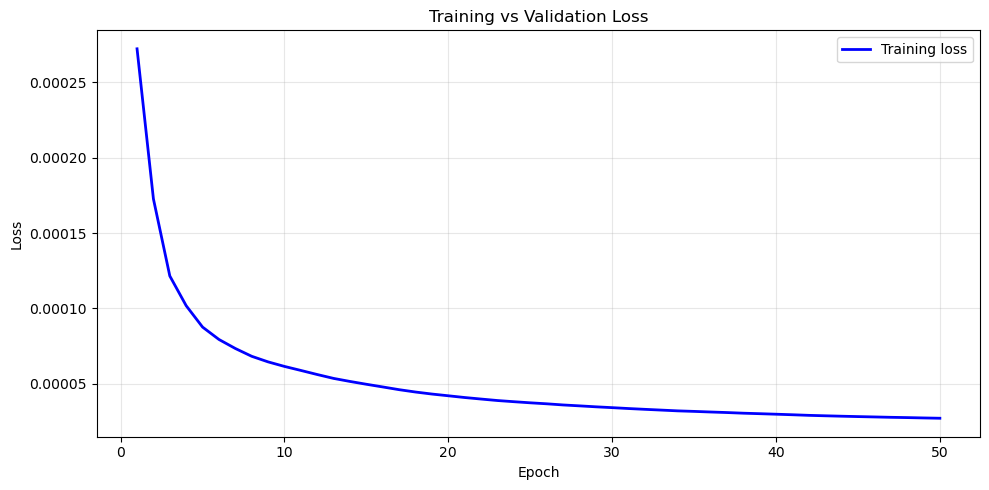

In [22]:
results['model'].plot_loss()

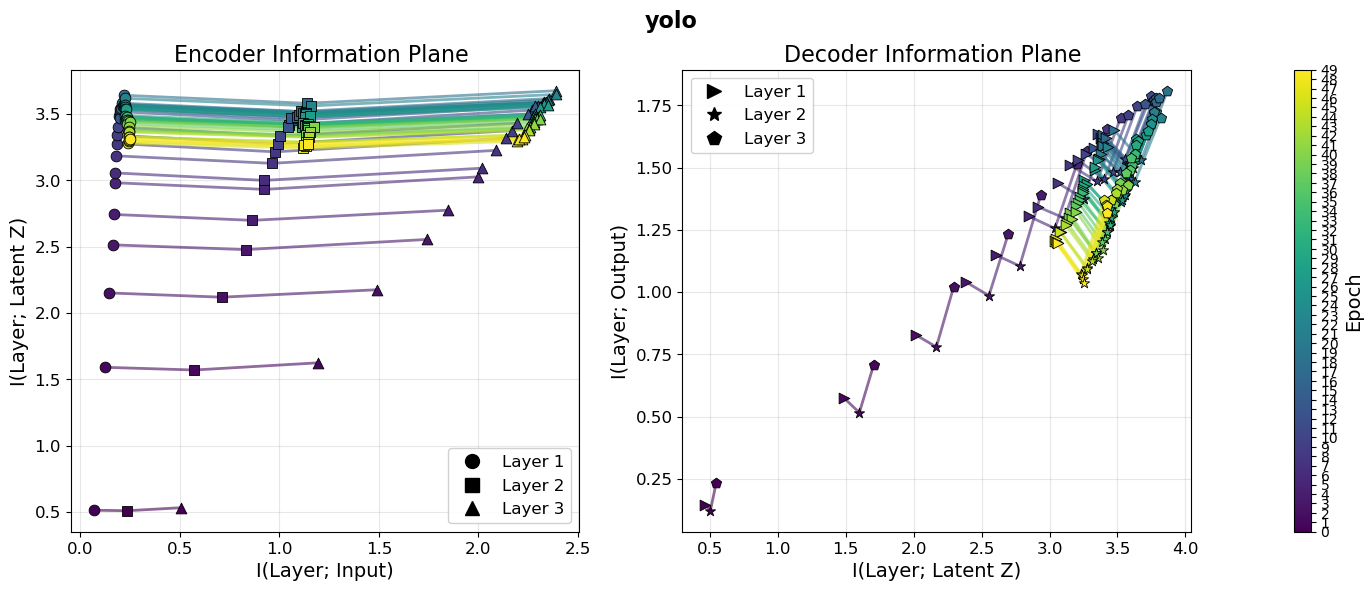

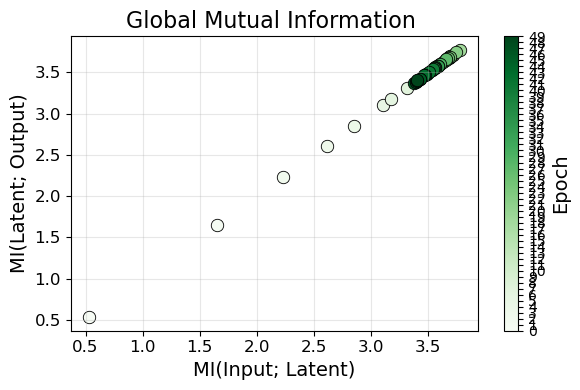

In [33]:
PlotInfoPlane(results['mi_history'], start_epoch=0, end_epoch=-1, Step=1, suptitle="yolo")

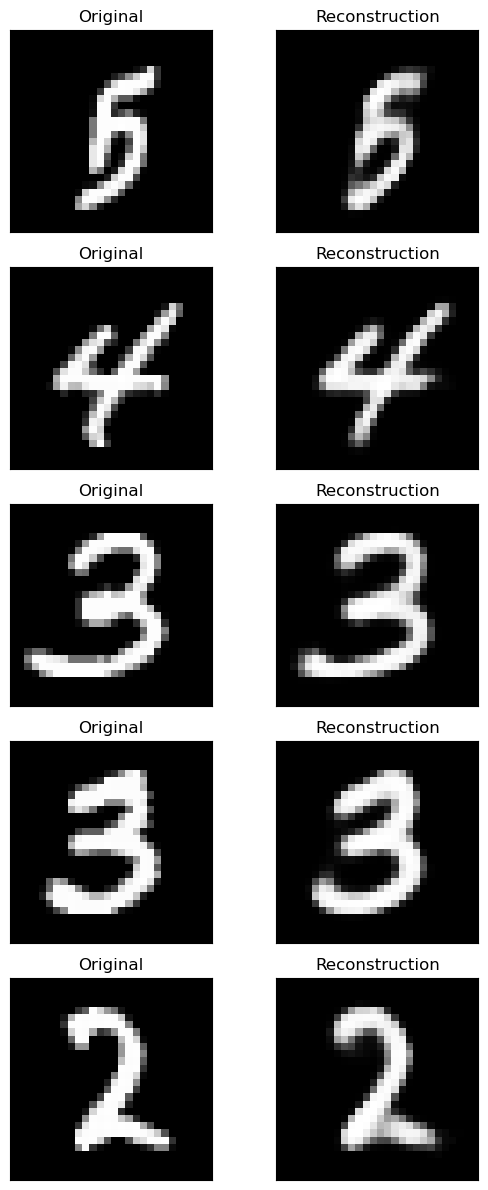

In [34]:
ShowSomeImages(results['model'], testDataset, device)

In [13]:
# import torch
# import torch.nn as nn
# import torch.nn.utils.parametrize as parametrize
# import torch.optim as optim
# import numpy as np
# from typing import Dict, Any, List, Optional, Callable

# ==========================================
# 1. NOISE FUNCTIONS & TOOLS
# ==========================================

def gaussian_noise(z: torch.Tensor, std: float) -> torch.Tensor:
    noise = torch.randn_like(z) * std
    noisy_z = z + noise
    return noisy_z

def bitflip_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    # Flip probability p
    flip_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[flip_mask] = -noisy_z[flip_mask]
    return noisy_z

def deactivate_input_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    # Dropout/Zeroing probability p
    deactivate_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[deactivate_mask] = 0.0
    return noisy_z

class ChannelAnalyzer:
    """
    Tools to compare Latent Space Transmission vs Direct Image Transmission
    under various noise conditions.
    """
    @staticmethod
    def compare_performance(model, dataset, device, noise_type="gaussian", param=0.5, num_samples=1000, renorm=True):
        """
        Runs the comparison and prints the MSE improvement.
        """
        # Select noise function
        noise_map = {
            "gaussian": gaussian_noise,
            "bitflip": bitflip_noise,
            "deactivate": deactivate_input_noise
        }
        noise_func = noise_map.get(noise_type, gaussian_noise)
        
        model.eval().to(device)
        latent_mse_list, direct_mse_list = [], []
        
        # Create a temporary loader for efficient batch processing
        loader = torch.utils.data.DataLoader(dataset, batch_size=min(num_samples, 100), shuffle=True)
        batches_needed = max(1, num_samples // loader.batch_size)
        
        print(f"\n--- Running Channel Analysis (Noise: {noise_type}, Param: {param}) ---")
        
        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= batches_needed: break
                
                # Flatten image: [Batch, 1, 28, 28] -> [Batch, 784]
                x = x.to(device).view(x.size(0), -1)
                
                # --- PATH A: Latent Channel Transmission ---
                # Encoder -> Z -> Noise -> Decoder
                z, _, _ = model.Encoding(x)
                
                # Optional: Renormalize Z to make noise relative to signal amplitude
                if renorm:
                    scale = torch.max(torch.abs(z)) + 1e-8
                    z_normalized = z / scale
                    z_noisy = noise_func(z_normalized, param) * scale
                else:
                    z_noisy = noise_func(z, param)
                    
                x_rec_latent = model.Decoding(z_noisy)
                
                # --- PATH B: Direct Channel Transmission ---
                # Image -> Noise
                x_noisy_direct = noise_func(x, param)
                
                # Calculate MSE for this batch
                # Axis 1 = sum over pixels, then mean over batch
                batch_mse_latent = torch.mean(torch.sum((x - x_rec_latent)**2, dim=1))
                batch_mse_direct = torch.mean(torch.sum((x - x_noisy_direct)**2, dim=1))
                
                latent_mse_list.append(batch_mse_latent.item())
                direct_mse_list.append(batch_mse_direct.item())

        # Aggregate results
        avg_latent_mse = np.mean(latent_mse_list)
        avg_direct_mse = np.mean(direct_mse_list)
        improvement = (avg_direct_mse - avg_latent_mse) / avg_direct_mse * 100
        
        print(f" > Direct Channel MSE: {avg_direct_mse:.4f}")
        print(f" > Latent Channel MSE: {avg_latent_mse:.4f}")
        print(f" > VAE Robustness Improvement: {improvement:.2f}%")
        
        return {"latent_mse": avg_latent_mse, "direct_mse": avg_direct_mse, "improvement": improvement}